# Laboratorio 3.6: Cuaderno del estudiante

## Información general

Este laboratorio es una continuación de los laboratorios guiados del Módulo 3.

En este laboratorio, evaluará el modelo que entrenó en los módulos anteriores. También calculará métricas basadas en los resultados de los datos de prueba.


## Presentación de la situación empresarial

Trabaja para un proveedor de atención médica y desea mejorar la detección de anomalías en los pacientes de ortopedia. 

Se le asignó la tarea de resolver este problema con el uso de machine learning (ML). Tiene acceso a un conjunto de datos que contiene seis funciones biomecánicas y un objetivo de *normal* o *anormal*. Puede usar este conjunto de datos para entrenar un modelo de ML para predecir si un paciente tendrá una anomalía.


## Acerca de este conjunto de datos

Este conjunto de datos biomédicos fue creado por el Dr. Henrique da Mota durante un periodo de residencia médica en el Group of Applied Research in Orthopaedics (GARO) del Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, Francia. Los datos se organizaron en dos tareas de clasificación diferentes pero que se relacionan. 

La primera tarea consiste en clasificar pacientes como pertenecientes a una de tres categorías: 

- *Normal* (100 pacientes)
- *Hernia de disco* (60 pacientes)
- *Espondilolistesis* (150 pacientes)

Para la segunda tarea, las categorías *hernia de disco* y *espondilolistesis* se fusionaron en una sola categoría que se denomina *anormal*. Por ende, la segunda tarea consiste en clasificar a los pacientes como pertenecientes a una de dos categorías: *normal* (100 pacientes) o *anormal* (210 pacientes).


## Información de atributos

Cada paciente está representado en el conjunto de datos por seis atributos biomecánicos que se derivan de la forma y la orientación de la pelvis y la columna lumbar (en este orden): 

- Pelvic incidence (Incidencia pélvica)
- Pelvic tilt (Inclinación pélvica)
- Lumbar lordosis angle (Ángulo de lordosis lumbar)
- Sacral slope (Pendiente sacra)
- Pelvic radius (Radio pélvico)
- Grade of spondylolisthesis (Grado de espondilolistesis)

Se usa la siguiente convención para las etiquetas de clase: 
- DH (hernia de disco)
- SL (espondilolistesis)
- NO (normal) 
- AB (anormal)

Para obtener más información sobre este conjunto de datos, consulte la [página web del conjunto de datos de la columna vertebral](http://archive.ics.uci.edu/ml/datasets/Vertebral+Column).


## Atribuciones del conjunto de datos

Este conjunto de datos se obtuvo de:
Dua, D. y Graff, C. (2019). Repositorio de Machine Learning de UCI (http://archive.ics.uci.edu/ml). Irvine, CA: Universidad de California, School of Information and Computer Science.


# Configuración del laboratorio

Debido a que esta solución se divide en varios laboratorios en el módulo, debe ejecutar las siguientes celdas para poder cargar los datos y entrenar el modelo que se implementará.

**Nota:** La configuración puede tardar hasta 5 minutos en completarse.

## Importación de los datos y entrenamiento del modelo

Ejecute las siguientes celdas para importar los datos y dejarlos listos para utilizarse. 

**Nota:** Las siguientes celdas representan los pasos clave de los laboratorios anteriores.


In [1]:
bucket='c190240a4907840l13104834t1w145414187560-labbucket-63vrud8r1osf'

In [2]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-12-11-10-21-58-256



2025-12-11 10:22:00 Starting - Starting the training job....
2025-12-11 10:22:25 Starting - Preparing the instances for training......
2025-12-11 10:23:01 Downloading - Downloading input data.....
2025-12-11 10:23:31 Downloading - Downloading the training image.............
2025-12-11 10:24:42 Training - Training image download completed. Training in progress..
2025-12-11 10:24:52 Uploading - Uploading generated training model...
2025-12-11 10:25:11 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-11-10-25-15-751


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-12-11-10-25-16-305


.......................................
...

# Paso 1: exploración de los resultados

El resultado del modelo será una probabilidad. Primero debe convertir esa probabilidad en una de las dos clases, *0* o *1*. Para ello, puede crear una función para realizar la conversión. Tenga en cuenta el uso del umbral en la función.

In [4]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


De acuerdo con estos resultados, puede ver que el modelo inicial podría no ser tan bueno. Es difícil diferenciar comparando unos cuantos valores.

A continuación, generará algunas métricas para ver cómo es el rendimiento del modelo.


# Paso 2: creación de la matriz de confusión

Una *matriz de confusión* es una de las maneras clave de medir el rendimiento de un modelo de clasificación. Es una tabla que mapea las predicciones correctas e incorrectas. Después de calcular una matriz de confusión para su modelo, puede generar varias otras estadísticas. Sin embargo, primero creará solo la matriz de confusión.

Para crear una matriz de confusión, necesita los valores objetivo de sus datos de prueba *y* el valor previsto. 

Obtenga los objetivos desde el DataFrame de prueba.

In [5]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

Ahora puede usar la biblioteca *scikit-learn*, que contiene una función para crear una matriz de confusión.

In [6]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


Sus resultados variarán, pero debe obtener resultados similares a este ejemplo:

_ | Normal | Abnormal
---------- | ----: | ----:
Normal | 7 | 3
Abnormal | 3 | 18



La tabla anterior muestra que el modelo predijo correctamente los valores *7 Normal* y *18 Abnormal*. Sin embargo, predijo incorrectamente los valores *3 Normal* y *3 Abnormal*. 

Con las bibliotecas de Python *seaborn* y *matplotlib*, puede trazar estos valores en un gráfico para hacerlos más fáciles de leer.

INFO:matplotlib.font_manager:generated new fontManager


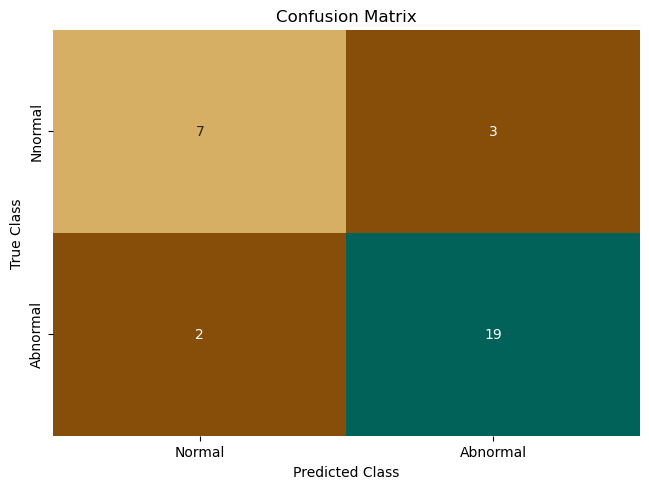

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

**Sugerencia:** Si el gráfico no se muestra la primera vez, intente ejecutar la celda de nuevo.

Si estos resultados son suficientemente buenos para su aplicación, el modelo podría ser suficientemente bueno. Sin embargo, debido a que predecir incorrectamente los valores *Normal* tiene consecuencias, es decir, no se encontró ninguna anomalía cuando de hecho había una, el foco debe estar en reducir este resultado.

# Paso 3: cálculo de las estadísticas de rendimiento

Si desea comparar este modelo con el siguiente modelo que cree, necesita algunas métricas que pueda registrar. Para un problema de clasificación binaria, se pueden usar los datos de la matriz de confusión para calcular diversas métricas.

Para comenzar, extraiga los valores de las celdas de la matriz de confusión como variables.

In [9]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 2
True Positive (TP) : 19


Ahora puede calcular algunas estadísticas.


### Sensibilidad

*Sensibilidad* también se conoce como *tasa de aciertos*, *exhaustividad* o *tasa de positivos reales (true positive rate, TPR)*. Mide la proporción de los positivos reales que se identificaron correctamente.

En este ejemplo, la sensibilidad es *la probabilidad de detectar una anomalía para pacientes con una anomalía*.

In [10]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%") 
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 90.47619047619048%
There is a 90.47619047619048% chance of detecting patients with an abnormality have an abnormality


**Pregunta:** ¿La sensibilidad es suficientemente buena para esta situación?


### Especificidad

La siguiente estadística es *especificidad*, que también se conoce como *negativo real*. Mide la proporción de los negativos reales que se identificaron correctamente.

En este ejemplo, la especificidad es *la probabilidad de detectar normal para pacientes que son normales*.

In [11]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


**Pregunta:** ¿La especificidad es demasiado baja, es la medida exacta o es de.masiado alta? ¿Qué valor le gustaría que se viera aquí, considerando la situación?



### Valores predictivos positivos y negativos

La *precisión*, o el *valor predictivo positivo*, es la proporción de resultados positivos.

En este ejemplo, el valor predictivo positivo es *la probabilidad de que los sujetos con un resultado positivo en el examen de detección realmente tengan una anomalía*.

In [12]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 86.36363636363636%
You have an abnormality, and the probablity that is correct is 86.36363636363636%


El *valor predictivo negativo*, es la proporción de resultados negativos.

En este ejemplo, el valor predictivo negativo es *la probabilidad de que los sujetos con un resultado negativo en el examen de detección realmente tengan una anomalía*.

In [13]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 77.77777777777779%
You don't have an abnormality, but there is a 77.77777777777779% chance that is incorrect


Piense en el impacto de estos valores. Si usted fuera un paciente, ¿cuánto debería preocuparse si el resultado de la prueba de una anomalía fuera positivo? Por el contrario, ¿cuánto debería tranquilizarlo si el resultado fuera negativo?


### Tasa de falsos positivos

La *tasa de falsos positivos (false positive rate, FPR)* es la probabilidad de que se genere una falsa alarma *se dará un resultado positivo cuando el valor real es negativo*. 

In [14]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


### Tasa de falsos negativos

La *tasa de falsos negativos* o *tasa de error* es *la probabilidad de que la prueba omita un positivo real*.

In [15]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 9.523809523809524%
There is a 9.523809523809524% chance that this negative result is incorrect.


### Tasa de falsos descubrimientos

En este ejemplo, la *tasa de falsos descubrimientos* es *la probabilidad de predecir una anomalía cuando el paciente no tiene una*.

In [16]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 13.636363636363635%
You have an abnormality, but there is a 13.636363636363635% chance this is incorrect.


### Exactitud general

¿Cuál es el grado de exactitud de su modelo?

In [17]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 83.87096774193549%


En resumen, calculó las siguientes métricas a partir de su modelo:

In [18]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%


**Tarea de desafío:** registre los valores anteriores, luego, vuelva al paso 1 y cambie el valor que se usó para el umbral. Los valores que debe probar son *.25* y *.75*. 

¿Esos valores marcaron una diferencia?

# ¡Felicitaciones!

Completó este laboratorio y ahora puede finalizarlo siguiendo las instrucciones en la guía del laboratorio.